In [ ]:
# %pip install numpy
# %pip install ipywidgets
# %pip install torch
# %pip install scikit-learn
# %pip install tensorflow
# %pip install opencv-python
# %pip install matplotlib
# %pip install kagglehub
# %pip install monai
# %pip install ingenii-quantum-hybrid-networks

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from monai.transforms import ScaleIntensity
import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from ingenii_quantum.hybrid_networks.layers import QuantumFCLayer


#### Download latest version https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/data

In [2]:
path = kagglehub.dataset_download(r"navoneel/brain-mri-images-for-brain-tumor-detection")
# print("Path to dataset files:", path)

#### Define dataset paths
#### !!! Remove .DS_Store from folders

In [4]:
# !rm -rf {path}/brain_tumor_dataset/yes/.DS_Store
# !rm -rf {path}/brain_tumor_dataset/no/.DS_Store

In [3]:
dataset_path_tumor = f'{path}/brain_tumor_dataset/yes'
dataset_path_norma = f'{path}/brain_tumor_dataset/no'

#### Count files in directory

In [4]:
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.endswith(('.jpg', '.JPG', '.png', '.jpeg'))])

print("Length dataset_path_tumor:", count_images(dataset_path_tumor))
print("Length dataset_path_norma:", count_images(dataset_path_norma))

Length dataset_path_tumor: 155
Length dataset_path_norma: 98


#### Check data

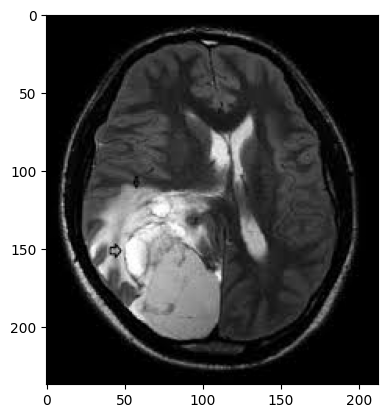

In [5]:
mri_image = cv2.imread(f'{dataset_path_tumor}/Y245.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(mri_image, cmap='gray')

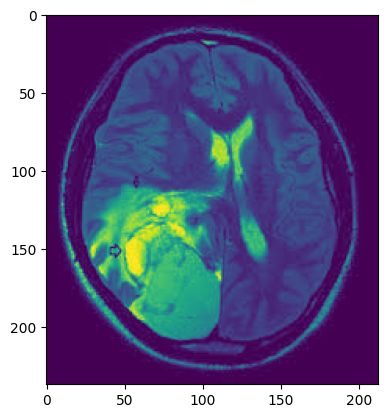

In [6]:
transform_img = ScaleIntensity(minv=0.0, maxv=1.0)
mri_image_scaled = transform_img(mri_image)
colored_mri = cm.viridis(mri_image_scaled)
plt.imshow(colored_mri)

#### Load and preprocess the images

In [7]:
img_size = (128, 128)

def load_images_from_folder(folder, label, target_size=img_size):
    """
    Loads images from a given folder and resizes them to the specified target size.
    Converts images to RGB and stores them as numpy arrays (3D).

    Args:
        folder (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A list of image data and their corresponding labels.
    """
    data, labels = [], []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path).convert("RGB").resize(target_size)
            data.append(np.array(img))
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
    return np.array(data), np.array(labels)


def load_and_limit_data(path, label, num_samples, target_size=img_size):
    """
    Loads and limits the number of images from a folder to a specified number of samples.
    Ensures images are resized to the specified target size.

    Args:
        path (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        num_samples (int): Maximum number of samples to load.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A numpy array of limited image data and their corresponding labels.
    """
    data, labels = load_images_from_folder(path, label, target_size)
    indices = np.random.choice(len(data), min(num_samples, len(data)), replace=False)
    data = data[indices]
    labels = labels[indices]
    return data, labels

#### Display images for train

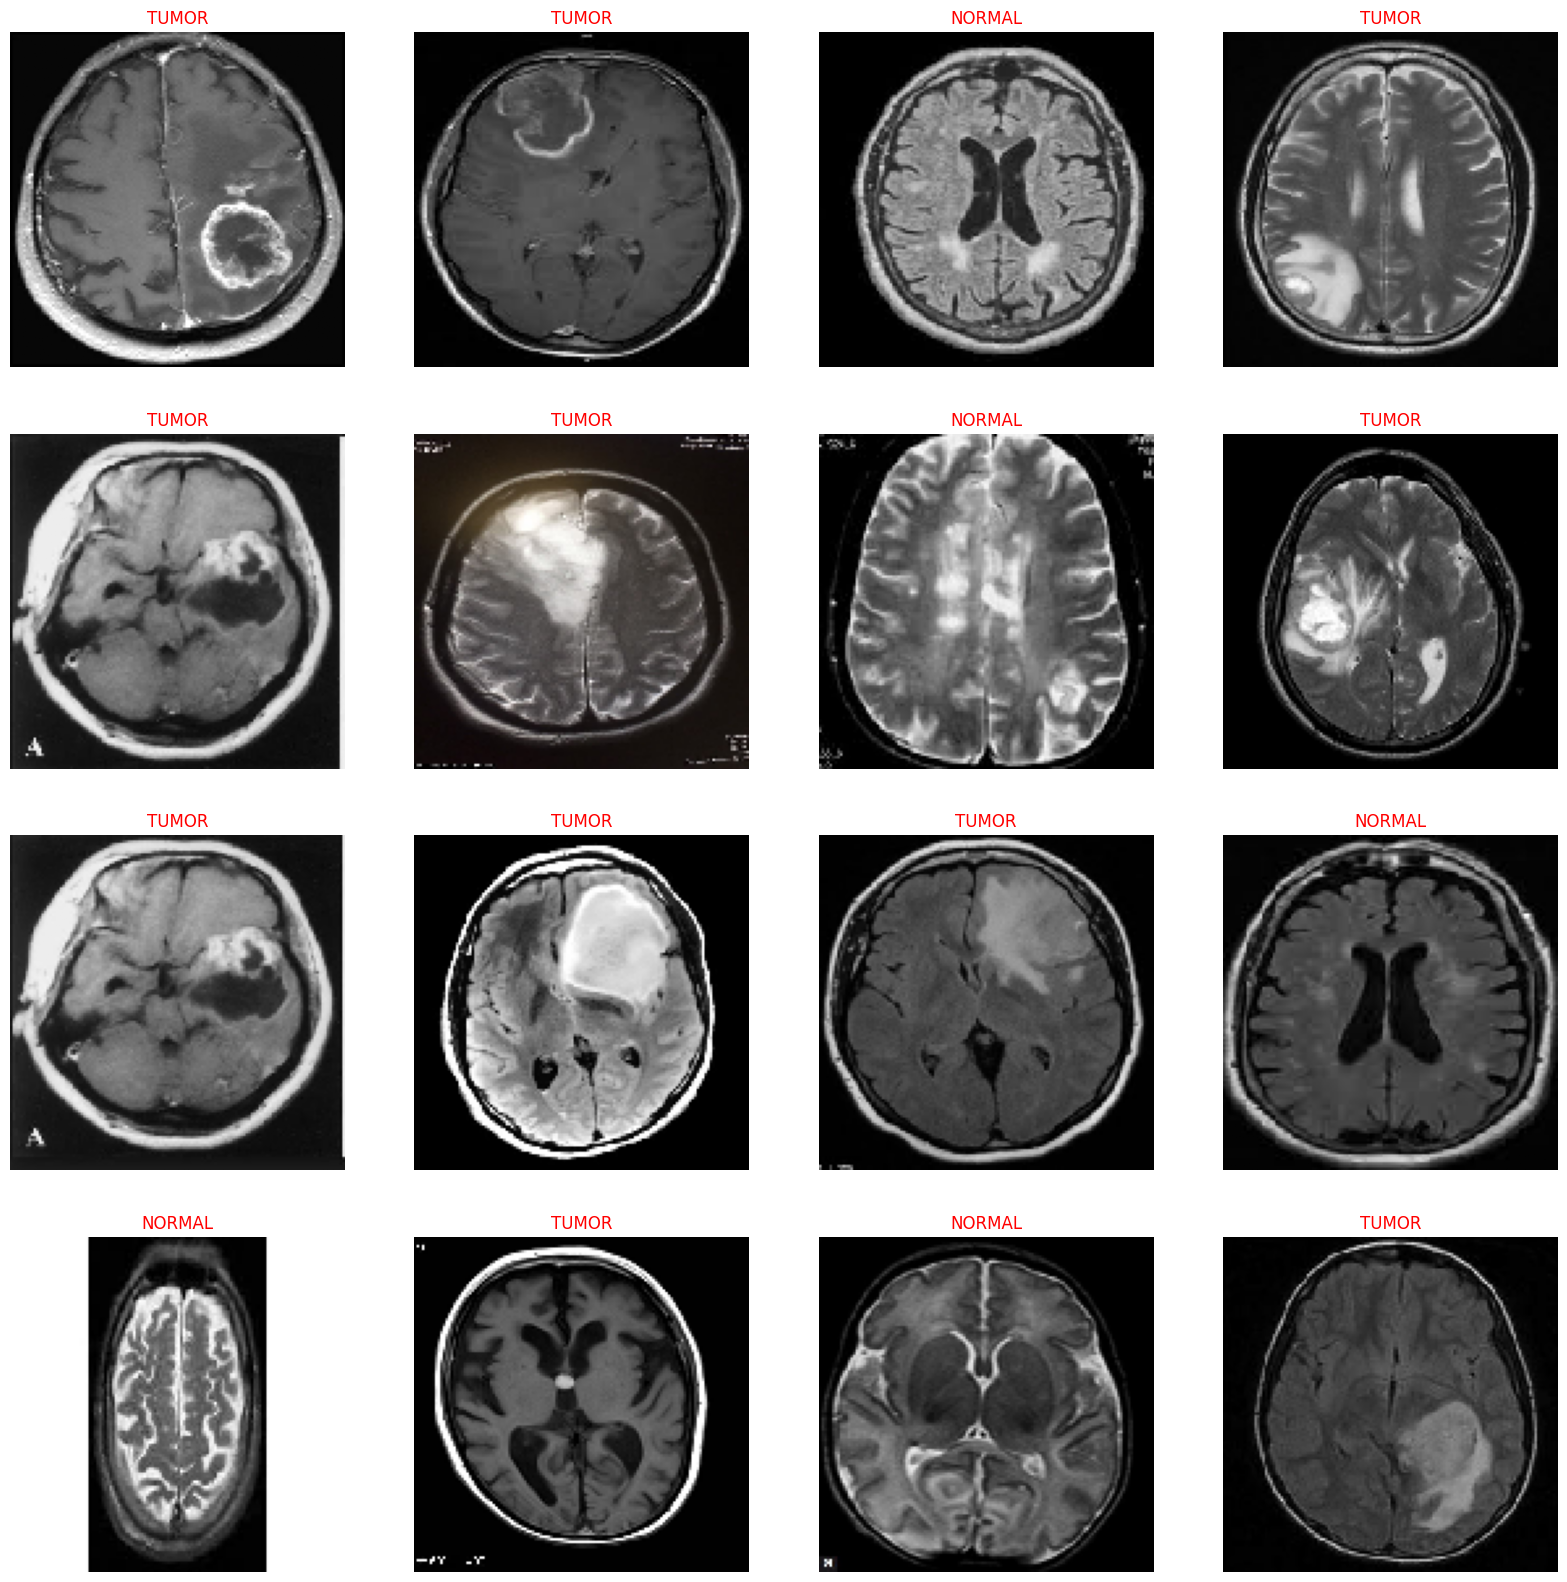

In [8]:
def load_file_paths_and_labels(directory, label):
    filepaths = [os.path.join(directory, fname) for fname in os.listdir(directory) if os.path.isfile(os.path.join(directory, fname))]
    labels = [label] * len(filepaths)
    return filepaths, labels

tumor_filepaths, tumor_labels = load_file_paths_and_labels(dataset_path_tumor, 'TUMOR')
normal_filepaths, normal_labels = load_file_paths_and_labels(dataset_path_norma, 'NORMAL')

all_filepaths = tumor_filepaths + normal_filepaths
all_labels = tumor_labels + normal_labels

combined = list(zip(all_filepaths, all_labels))
np.random.shuffle(combined)
all_filepaths, all_labels = zip(*combined)

label_to_index = {'TUMOR': 0, 'NORMAL': 1}
categorical_labels = np.array([label_to_index[label] for label in all_labels])

def scalar(img):
    return img

def custom_generator(filepaths, labels, batch_size, img_size, preprocessing_function=None):
    while True:
        for i in range(0, len(filepaths), batch_size):
            batch_filepaths = filepaths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            
            images = []
            for filepath in batch_filepaths:
                img = load_img(filepath, target_size=img_size)
                img_array = img_to_array(img)
                if preprocessing_function:
                    img_array = preprocessing_function(img_array)
                images.append(img_array)
            
            yield np.array(images), np.array(batch_labels)

img_size = img_size
batch_size = 32

train_gen = custom_generator(all_filepaths, categorical_labels, batch_size, img_size, preprocessing_function=scalar)

images, labels = next(train_gen)

classes = list(label_to_index.keys())

plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    class_index = labels[i]
    class_name = classes[class_index]
    plt.title(class_name, color='red', fontsize=12)
    plt.axis('off')

plt.show()

#### Get training and testing data

In [9]:
tumor_data, tumor_labels = load_and_limit_data(dataset_path_tumor, label=1, num_samples=98)
normal_data, normal_labels = load_and_limit_data(dataset_path_norma, label=0, num_samples=155)

all_data = np.concatenate([tumor_data, normal_data], axis=0)
all_labels = np.concatenate([tumor_labels, normal_labels], axis=0)

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.2, random_state=42)

# Convert to (N, C, H, W)
X_train = np.transpose(X_train, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))

# Convert to one-hot encoding
y_train = np.eye(2)[y_train]
y_test = np.eye(2)[y_test]

#### Quantum layer

In [10]:
num_qubits = 8

qnn_layer = QuantumFCLayer(
    input_size=num_qubits,
    n_layers=1,
    encoding='qubit',
    ansatz=1,
    observables=["Z" + "I" * (num_qubits - 1)],
    backend='default.qubit'
).create_layer(type_layer='torch')

#### Setting quantum model

In [11]:
class QuantumCNN(nn.Module):
    def __init__(self, num_classes=2, num_qubits=8):
        super(QuantumCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Global pooling and flattening
        self.global_pool = nn.AdaptiveAvgPool2d((2, 2))
        self.flattened_size = 128 * 2 * 2

        self.quantum_layer = qnn_layer
        
        # Fully connected layers
        self.fc1 = nn.Linear(513, 512) 
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        x = self.global_pool(x)
        
        x = x.reshape(x.size(0), -1)

        quantum_input = x[:, :8]
        
        q_out = self.quantum_layer(quantum_input)
        
        # Concatenate classical CNN features with quantum output
        x = torch.cat((x, q_out), dim=1)

        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        
        x = F.relu(self.fc2(x))
        
        x = self.fc3(x)
        
        return x


#### Initialize the model

In [12]:
quantum_model = QuantumCNN(num_classes=2)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(quantum_model.parameters(), lr=0.001)

#### Training function

In [13]:
def fit_quantum_model(model, X_train, y_train, epochs=20, batch_size=32, patience=5):
    """
    Trains a PyTorch quantum model with the given training data.
    
    Args:
        model (torch.nn.Module): The PyTorch model to train.
        X_train (np.ndarray): Training data, expected shape (num_samples, channels, height, width).
        y_train (np.ndarray): Training labels, one-hot encoded.
        epochs (int): Number of epochs to train the model.
        batch_size (int): Batch size for training.
        patience (int): Early stopping patience (not implemented here).

    Returns:
        dict: Training history with 'loss' and 'accuracy' for each epoch.
    """
    model.train()
    history = {'loss': [], 'accuracy': []}

    # Ensure input dimensions match the expected shape
    if len(X_train.shape) == 2:
        raise ValueError(
            "X_train must be reshaped to 4D tensor with shape "
            "(num_samples, channels, height, width) before calling this function."
        )

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # Shape: (N, C, H, W)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Shape: (N, num_classes)

    # Create DataLoader
    dataset = TensorDataset(X_train_tensor, y_train_tensor)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0

        for X_batch, y_batch in data_loader:
            optimizer.zero_grad()

            # Forward pass
            outputs = model(X_batch)

            # Compute loss
            loss = criterion(outputs, y_batch.argmax(dim=1))
            epoch_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Compute accuracy
            _, predicted = torch.max(outputs, dim=1)
            acc = (predicted == y_batch.argmax(dim=1)).float().mean().item()
            epoch_accuracy += acc

        # Average metrics for the epoch
        avg_epoch_loss = epoch_loss / len(data_loader)
        avg_epoch_accuracy = epoch_accuracy / len(data_loader)
        history['loss'].append(avg_epoch_loss)
        history['accuracy'].append(avg_epoch_accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_epoch_loss:.4f}, Accuracy: {avg_epoch_accuracy:.4f}")

    return history

#### Training the model

In [14]:
quantum_history = fit_quantum_model(quantum_model, X_train, y_train, epochs=50)

Epoch [1/50], Loss: 0.6737, Accuracy: 0.5830
Epoch [2/50], Loss: 0.5815, Accuracy: 0.7143
Epoch [3/50], Loss: 0.5563, Accuracy: 0.7098
Epoch [4/50], Loss: 0.5184, Accuracy: 0.7304
Epoch [5/50], Loss: 0.4596, Accuracy: 0.7821
Epoch [6/50], Loss: 0.5522, Accuracy: 0.7446
Epoch [7/50], Loss: 0.5473, Accuracy: 0.7384
Epoch [8/50], Loss: 0.4967, Accuracy: 0.7482
Epoch [9/50], Loss: 0.4764, Accuracy: 0.7634
Epoch [10/50], Loss: 0.4221, Accuracy: 0.8268
Epoch [11/50], Loss: 0.4365, Accuracy: 0.8054
Epoch [12/50], Loss: 0.3801, Accuracy: 0.8348
Epoch [13/50], Loss: 0.3887, Accuracy: 0.8268
Epoch [14/50], Loss: 0.3842, Accuracy: 0.8107
Epoch [15/50], Loss: 0.4235, Accuracy: 0.7857
Epoch [16/50], Loss: 0.3565, Accuracy: 0.8357
Epoch [17/50], Loss: 0.4482, Accuracy: 0.7929
Epoch [18/50], Loss: 0.3584, Accuracy: 0.8348
Epoch [19/50], Loss: 0.4197, Accuracy: 0.7884
Epoch [20/50], Loss: 0.3504, Accuracy: 0.8509
Epoch [21/50], Loss: 0.3269, Accuracy: 0.8536
Epoch [22/50], Loss: 0.3301, Accuracy: 0.87

#### Plotting accuracy and loss

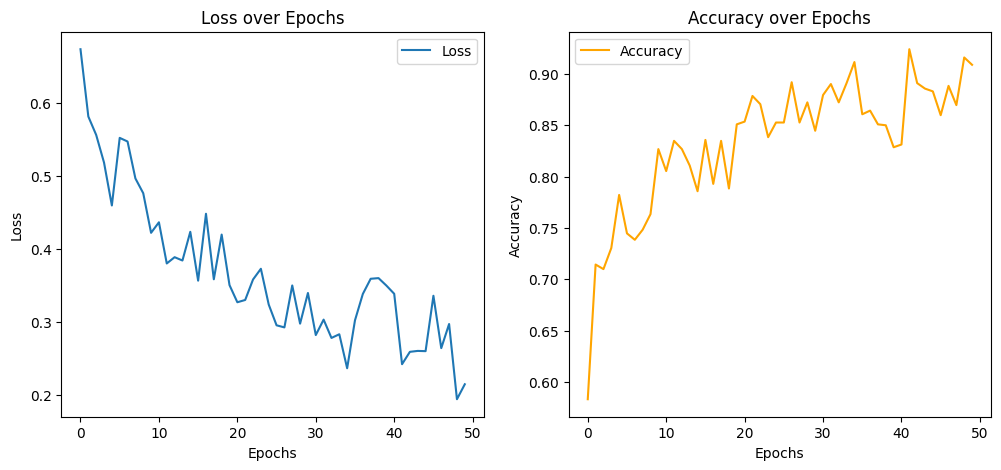

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(quantum_history['loss'], label='Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(quantum_history['accuracy'], label='Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### The evaluation of model

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
quantum_model.to(device)

y_train_indices = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long).to(device)  # Shape: (156,)
y_test_indices = torch.tensor(np.argmax(y_test, axis=1), dtype=torch.long).to(device)   # Shape: (40,)

quantum_model.eval()

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)  # Shape: (40, 3, 224, 224)

#### Evaluate performance

In [17]:
with torch.no_grad():
    outputs = quantum_model(X_test_tensor)

y_pred = torch.argmax(outputs, dim=1).cpu().numpy()
y_test_labels = y_test_indices.cpu().numpy()

print(f"Test Accuracy: {accuracy_score(y_test_labels, y_pred) * 100:.2f}%")
print(classification_report(y_test_labels, y_pred, target_names=['Normal', 'Tumor']))

Test Accuracy: 80.00%
              precision    recall  f1-score   support

      Normal       0.76      0.84      0.80        19
       Tumor       0.84      0.76      0.80        21

    accuracy                           0.80        40
   macro avg       0.80      0.80      0.80        40
weighted avg       0.80      0.80      0.80        40



#### Compute evaluation metrics

In [18]:
y_test_labels = torch.argmax(torch.tensor(y_test), dim=1).numpy()

if y_pred.ndim == 1:
    y_pred_labels = y_pred
else:
    y_pred_labels = torch.argmax(torch.tensor(y_pred), dim=1).numpy()

classification_rep = metrics.classification_report(y_test_labels, y_pred_labels, output_dict=True, zero_division=True)

conf_matrix = metrics.confusion_matrix(y_test_labels, y_pred_labels)

roc_auc = metrics.roc_auc_score(y_test_labels, y_pred_labels)

print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)
print(f"ROC AUC Score: {roc_auc}")

Classification Report:
 {'0': {'precision': 0.7619047619047619, 'recall': 0.8421052631578947, 'f1-score': 0.8, 'support': 19.0}, '1': {'precision': 0.8421052631578947, 'recall': 0.7619047619047619, 'f1-score': 0.8, 'support': 21.0}, 'accuracy': 0.8, 'macro avg': {'precision': 0.8020050125313283, 'recall': 0.8020050125313283, 'f1-score': 0.8, 'support': 40.0}, 'weighted avg': {'precision': 0.8040100250626565, 'recall': 0.8, 'f1-score': 0.8, 'support': 40.0}}
Confusion Matrix:
 [[16  3]
 [ 5 16]]
ROC AUC Score: 0.8020050125313283


#### Predicted probability for Positive Class

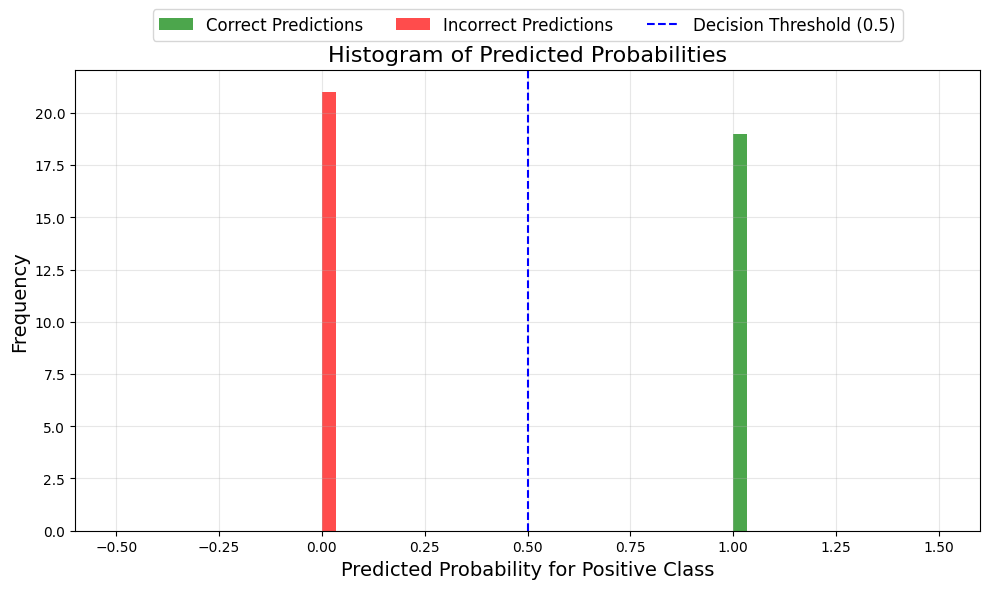

In [19]:
if isinstance(y_pred, np.ndarray):
    y_pred = torch.tensor(y_pred, dtype=torch.float32)

predictions = torch.round(y_pred)
correct_predictions = (predictions == 1)
incorrect_predictions = ~correct_predictions

correct_probs = y_pred[correct_predictions]
incorrect_probs = y_pred[incorrect_predictions]

plt.figure(figsize=(10, 6))

plt.hist(
    correct_probs.numpy(), 
    bins=30, 
    alpha=0.7, 
    color='green', 
    label='Correct Predictions'
)

plt.hist(
    incorrect_probs.numpy(), 
    bins=30, 
    alpha=0.7, 
    color='red', 
    label='Incorrect Predictions'
)

plt.axvline(0.5, color='blue', linestyle='--', label='Decision Threshold (0.5)', linewidth=1.5)

plt.title('Histogram of Predicted Probabilities', fontsize=16)
plt.xlabel('Predicted Probability for Positive Class', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


#### PCA of model prediction

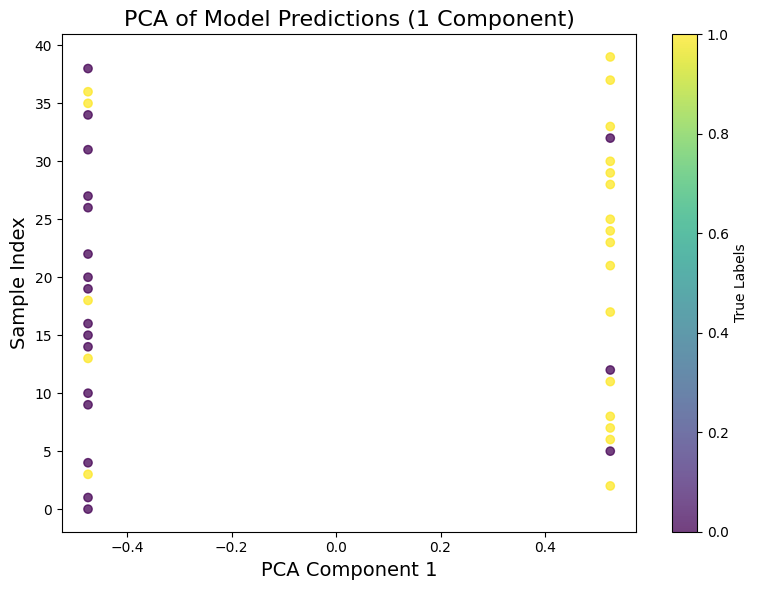

In [20]:
labels_test_reshaped = y_pred.reshape(-1, 1)

pca = PCA(n_components=1)
features_pca = pca.fit_transform(labels_test_reshaped)

y_test_labels = torch.argmax(torch.tensor(y_test), dim=1).numpy()

plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], range(len(features_pca)), c=y_test_labels, cmap='viridis', alpha=0.75)

plt.colorbar(label='True Labels')
plt.title('PCA of Model Predictions (1 Component)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('Sample Index', fontsize=14)

plt.tight_layout()
plt.show()

#### Plot the confusion matrix

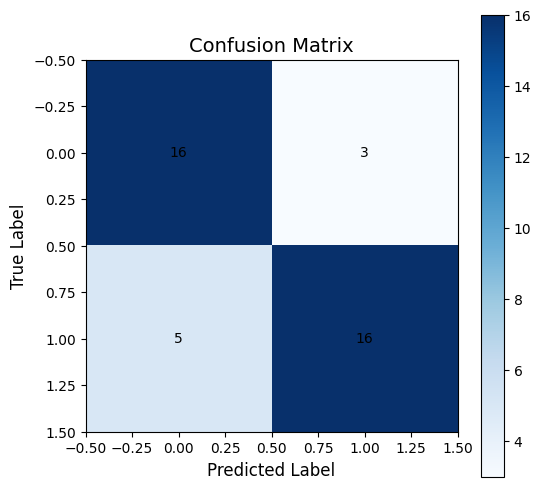

In [21]:
plt.figure(figsize=(6, 6))
plt.title("Confusion Matrix", fontsize=14)
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues, aspect='equal')
plt.colorbar()

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f"{conf_matrix[i, j]}", ha="center", va="center", color="black", fontsize=10)

plt.show()